In [142]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import robot_vlp.data_collection.experment_processing as ep
import robot_vlp.modeling.gen_cnc_vlp_model as vlp
import robot_vlp.data_collection.communication as c
import matplotlib.patches as patches
import pickle

from robot_vlp.config import EXPERIMENT_DATA_DIR, VLP_MODELS_DIR, FIGURES_DIR, INTERIM_DATA_DIR


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Vive driven robot

In [143]:
vlp_model = vlp.load_vlp_models()['high_acc']
# df_lst = []
# for i in range(0,10):
#     path = EXPERIMENT_DATA_DIR/f'Robot/exp1_{i}.csv'
#     df_lst.append(ep.process_robot_exp_file(path, vlp_model))
# df = pd.concat(df_lst[:-1])

df_lst = []
for i in range(10):
    test_file = INTERIM_DATA_DIR / 'exp_vive_navigated_paths'/f'exp1_{i}_high_acc.csv'
    df = pd.read_csv(test_file)
    df_lst.append(df)
df = pd.concat(df_lst[:])

In [144]:
train_df = pd.concat(df_lst[:-1])
mean = ep.filter_outliers(train_df['vive_location_change'],threshold= 3).mean()
std = ep.filter_outliers(train_df['vive_location_change'],threshold= 3).std()
print(f"move forward distance mean (m): {mean}")
print(f"move forward std: {std}")

step_counts = 445
enc_per_cm =   step_counts / (mean*100)
print(f'encoder counts per cm : {enc_per_cm}')

# put this in experment_processing.py 
# put this in EKF.py



move forward distance mean (m): 0.11176356631844775
move forward std: 0.0014035857212984153
encoder counts per cm : 39.81619544351888


In [145]:
def remove_outliers(x, y, threshold=2):
    """Removes points where residuals are greater than threshold * std."""
    initial_fit = np.polyfit(x, y, deg=1)
    predicted_y = np.polyval(initial_fit, x)
    residuals = y - predicted_y
    std_resid = np.std(residuals)
    mask = np.abs(residuals) < threshold * std_resid
    return x[mask], y[mask]



df = pd.concat(df_.iloc[1:] for df_ in df_lst[:-1])
turn_df = df[df['encoder_heading_change'] !=0]
clockwise_turn_df = turn_df[(turn_df['encoder_heading_change_step']>0) & (turn_df['vive_heading_change'] > 0) ]
anticlockwise_turn_df = turn_df[(turn_df['encoder_heading_change_step']<0) & (turn_df['vive_heading_change'] < 0) ]

# Apply outlier removal before fitting
cw_x, cw_y = remove_outliers(clockwise_turn_df['encoder_heading_change_step'].values,
                              clockwise_turn_df['vive_heading_change'].values)

cw_coef = np.polyfit(cw_x, cw_y, deg=1)
cw_line = np.poly1d(cw_coef)

acw_x, acw_y = remove_outliers(anticlockwise_turn_df['encoder_heading_change_step'].values,
                               anticlockwise_turn_df['vive_heading_change'].values)

acw_coef = np.polyfit(acw_x, acw_y, deg=1)
acw_line = np.poly1d(acw_coef)


### Function to put into experiment_processing.py

acw_line, cw_line




(poly1d([ 0.18816057, -0.82087375]), poly1d([0.18951681, 1.00878798]))

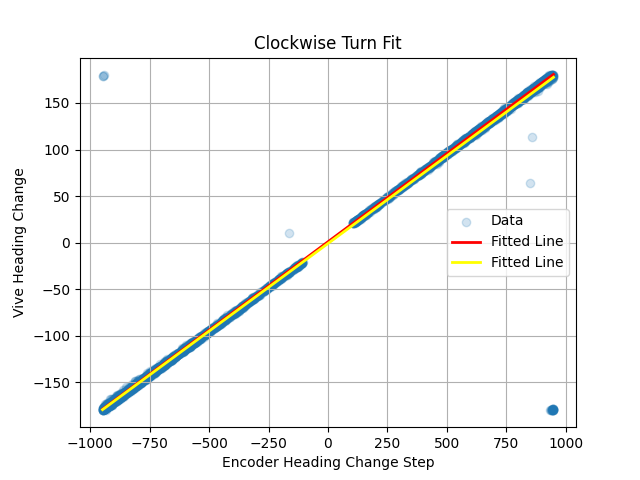

In [159]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
# Scatter plot
plt.scatter(turn_df['encoder_heading_change_step'], turn_df['vive_heading_change'], label='Data', alpha=0.2)

# Generate x-values for the line
x1_vals = np.linspace(clockwise_turn_df['encoder_heading_change_step'].min(),
                     clockwise_turn_df['encoder_heading_change_step'].max(), 100)

x2_vals = np.linspace(anticlockwise_turn_df['encoder_heading_change_step'].min(),
                     anticlockwise_turn_df['encoder_heading_change_step'].max(), 100)


# Compute corresponding y-values using the polynomial
y1_vals = cw_line(x1_vals)
y2_vals = acw_line(x2_vals)

x_all = np.linspace(turn_df['encoder_heading_change_step'].min(), turn_df['encoder_heading_change_step'].max(), 100)
y1_vals_all = cw_line(x_all)
y2_vals_all = acw_line(x_all)
plt.plot(x_all, y1_vals_all, color='red', label='Fitted Line', linewidth=2)
plt.plot(x_all, y2_vals_all, color='yellow', label='Fitted Line', linewidth=2)


# # Overlay the line
# plt.plot(x1_vals, y1_vals, color='red', label='Fitted Line', linewidth=2)
# plt.plot(x2_vals, y2_vals, color='red', label='Fitted Line', linewidth=2)

# Labels and legend
plt.xlabel('Encoder Heading Change Step')
plt.ylabel('Vive Heading Change')
plt.title('Clockwise Turn Fit')
plt.legend()
plt.grid(True)
plt.show()


### Generated navigation points plot

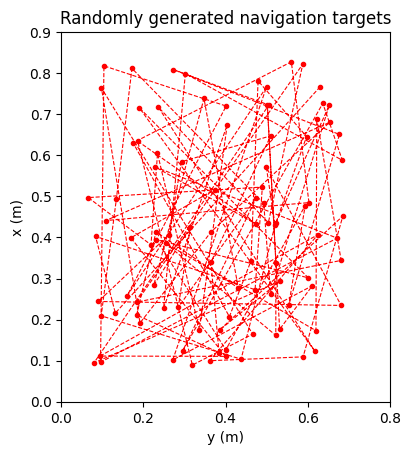

In [44]:

def generate_random_points(num_points, x_range, y_range, min_distance):
    """
    Generates random points within specified x and y ranges,
    ensuring a minimum distance between consecutive points.
    
    Args:
        num_points (int): Number of points to generate.
        x_range (tuple): Tuple specifying the (lower, upper) limits for the x-coordinate.
        y_range (tuple): Tuple specifying the (lower, upper) limits for the y-coordinate.
        min_distance (float): Minimum distance between consecutive points.
    
    Returns:
        np.ndarray: Array of generated points with shape (num_points, 2).
    """
    x_lower, x_upper = x_range
    y_lower, y_upper = y_range

    # Initialize an empty list for the target points
    all_targets = []

    # Generate the first random point within the specified ranges
    x = np.random.uniform(x_lower, x_upper)
    y = np.random.uniform(y_lower, y_upper)
    all_targets.append([x, y])

    # Generate the remaining points
    while len(all_targets) < num_points:
        x = np.random.uniform(x_lower, x_upper)
        y = np.random.uniform(y_lower, y_upper)
        # Check the distance to the last point
        last_x, last_y = all_targets[-1]
        distance = np.sqrt((x - last_x)**2 + (y - last_y)**2)
        if distance >= min_distance:
            all_targets.append([x, y])

    # Convert to a numpy array
    return np.array(all_targets)

# Example usage
x_range = (0.05, 0.7)  # Lower and upper limits for x
y_range = (0.05, 0.85)   # Lower and upper limits for y
num_points = 500
min_distance = 0.1
np.random.seed(3)  # exp1_1
all_targets = generate_random_points(num_points, x_range, y_range, min_distance)



fig = plt.figure()
ax = fig.add_subplot(111)  # add a single subplot

ax.plot(all_targets[2:100, 0], all_targets[2:100, 1],
        linestyle='--',  # dashed line style
        marker='.',      # dot markers
        linewidth=0.8,
        c = 'r',
        label = 'target points'
        )   # thinner line




ax.set_aspect('equal')  # make the axes square
ax.set_xlim(0,0.8)
ax.set_ylim(0,0.9)

ax.set_ylabel('x (m)')
ax.set_xlabel('y (m)')


plt.title('Randomly generated navigation targets')

# plt.savefig(FIGURES_DIR/'methodology-robot_nav_ponts.png')
plt.show()


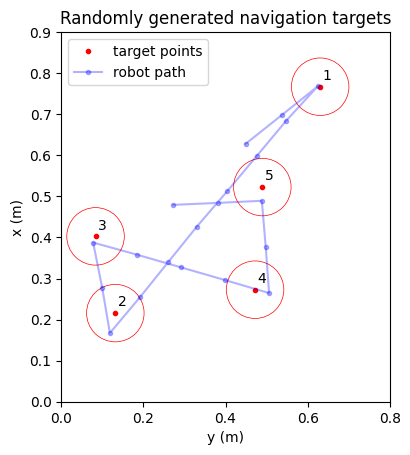

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)  # add a single subplot

ax.plot(all_targets[2:7, 0], all_targets[2:7, 1],
        linestyle='',  # dashed line style
        marker='.',      # dot markers
        linewidth=0.8,
        c = 'r',
        label = 'target points'
        )   # thinner line


# Loop through each point in the selected subset
for x, y in zip(all_targets[2:7, 0], all_targets[2:7, 1]):
    circle = patches.Circle((x, y), radius=0.07, fill=False, edgecolor='red', linewidth=0.5)
    ax.add_patch(circle)

for i, (x, y) in enumerate(zip(all_targets[2:7, 0], all_targets[2:7, 1]), start=1):
    ax.annotate(str(i), (x, y),
                textcoords="offset points",  # how to position the text
                xytext=(5, 5),              # offset (x,y) in points
                ha='center')  

# ax.plot(all_targets[7:20, 0], all_targets[7:20, 1],
#         linestyle='',  # dashed line style
#         marker='.',      # dot markers
#         linewidth=0.4,
#         alpha = 0.6)   # thinner line

plt.plot(df_lst[0]['x_hist'].iloc[10:30], df_lst[0]['y_hist'].iloc[10:30], 
         marker = '.', 
         c = 'b', 
         alpha = 0.3,
         label = 'robot path')



ax.set_aspect('equal')  # make the axes square
ax.set_xlim(0,0.8)
ax.set_ylim(0,0.9)

ax.set_ylabel('x (m)')
ax.set_xlabel('y (m)')
plt.legend()

plt.title('Randomly generated navigation targets')

plt.savefig(FIGURES_DIR/'methodology-robot_nav_ponts_exa.png')
plt.show()


### Stats for step distnace

In [15]:
[len(df) for df in df_lst]

[1685, 1727, 1522, 1742, 1060, 1498, 1159, 1757, 682, 354]

In [16]:
df = pd.concat(df_lst[:-1])

In [17]:
len(df)

12832

In [18]:
move_df = df[df['encoder_heading_change'] ==0]
turn_df = df[df['encoder_heading_change'] !=0]

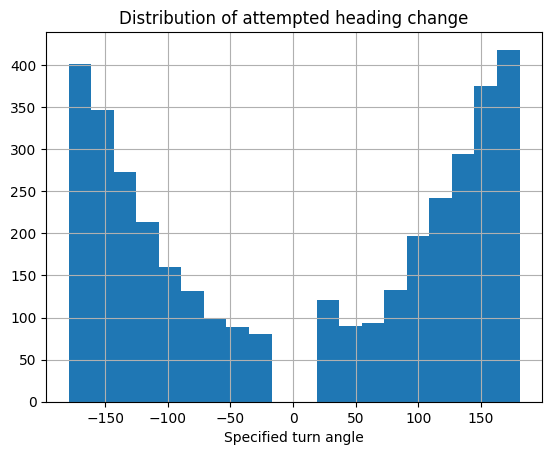

In [20]:
plt.figure()
turn_df['encoder_heading_change'].hist(bins = 20)
plt.title('Distribution of attempted heading change')
plt.xlabel('Specified turn angle')
plt.savefig(FIGURES_DIR/'methodology-robot_nav_turn_dist.png')

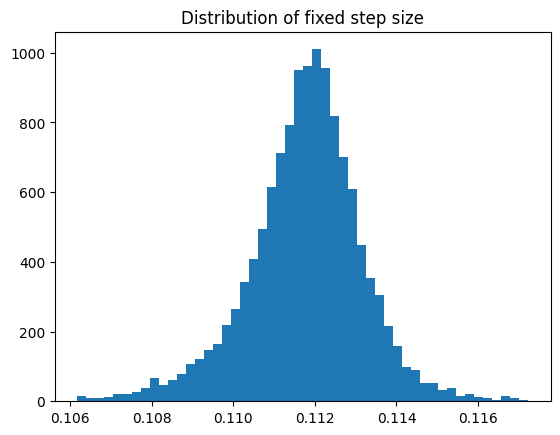

In [21]:
_ = plt.hist(ep.filter_outliers(df['vive_location_change'], threshold=3), bins = 50)
plt.title("Distribution of fixed step size")
plt.savefig(FIGURES_DIR/'methodology-robot_nav_step_err.png')

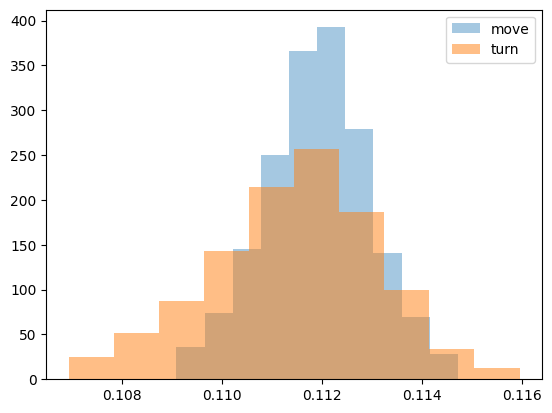

In [22]:
plt.hist(ep.filter_outliers(move_df['vive_location_change']), label = 'move', alpha = 0.4, density= True)
plt.hist(ep.filter_outliers(turn_df['vive_location_change']), label = 'turn', alpha = 0.5, density= True)
plt.legend()

### Deriving rotation error

In [23]:

move_df = df[df['encoder_heading_change_step'] == 0].iloc[1:-1]
turn_df = df[df['encoder_heading_change_step'] != 0].iloc[1:-1]
turn_df['enc_per_deg'] = (turn_df['encoder_heading_change_step']/turn_df['vive_heading_change'])
turn_df = turn_df[turn_df['enc_per_deg'] > 0 ]  # remove 'overturned'

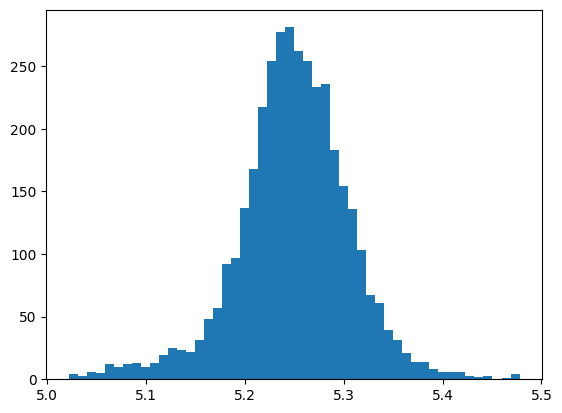

In [24]:
_ = plt.hist(ep.filter_outliers(turn_df['enc_per_deg'], threshold= 3), bins = 50)


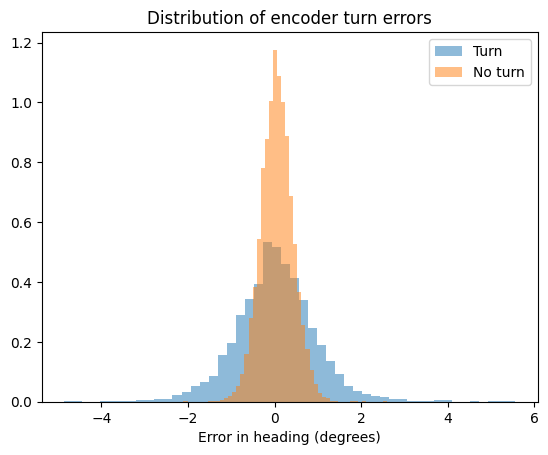

In [25]:
_ = plt.hist(ep.filter_outliers(turn_df['encoder_heading_change_err'], threshold= 8), bins = 50, density=True, alpha = 0.5, label = 'Turn')
_ = plt.hist(ep.filter_outliers(move_df['encoder_heading_change_err'], threshold= 8), bins = 50, density=True, alpha = 0.5, label = 'No turn')
plt.title("Distribution of encoder turn errors")
plt.xlabel('Error in heading (degrees)')
plt.legend()
plt.savefig(FIGURES_DIR/'methodology-robot_nav_turn_err.png')

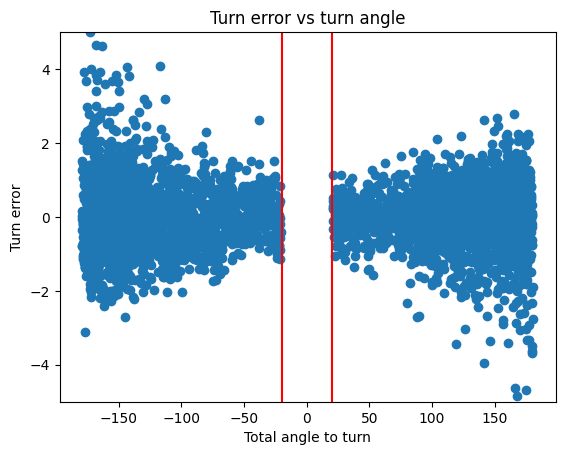

In [26]:
plt.scatter(turn_df['encoder_heading_change'] , turn_df['encoder_heading_change_err'])
plt.axvline(-20, c = 'r')
plt.axvline(20, c = 'r')
plt.title('Turn error vs turn angle')
plt.xlabel('Total angle to turn')
plt.ylabel('Turn error')
plt.ylim(-5,5)
plt.savefig(FIGURES_DIR/'methodology-robot_nav_turn_err_vs_turn_angle.png')


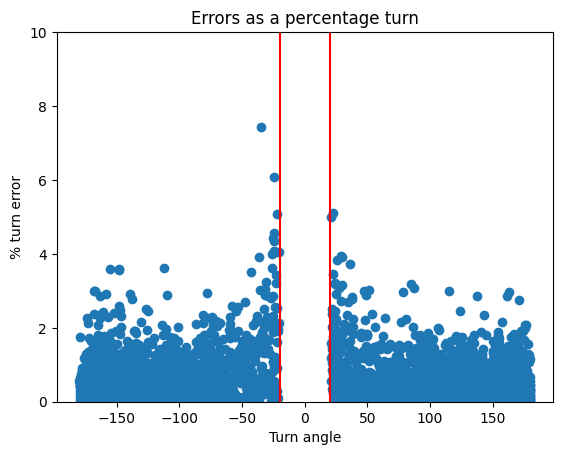

In [27]:
plt.scatter(turn_df['vive_heading_change'], turn_df['encoder_heading_change_err'].abs()/turn_df['vive_heading_change'].abs() * 100)
plt.ylim(0,10
         )
plt.axvline(-20, c = 'r')
plt.axvline(20, c = 'r')

plt.title('Errors as a percentage turn')
plt.ylabel('% turn error')
plt.xlabel('Turn angle')

plt.savefig(FIGURES_DIR/'methodology-robot_nav_turn_err_as_percentage.png')

In [28]:
turn_df['enc_per_deg'] = (turn_df['encoder_heading_change_step']/turn_df['vive_heading_change'])

Text(0.5, 1.0, 'Determining the how many encoder counts per degree rotation')

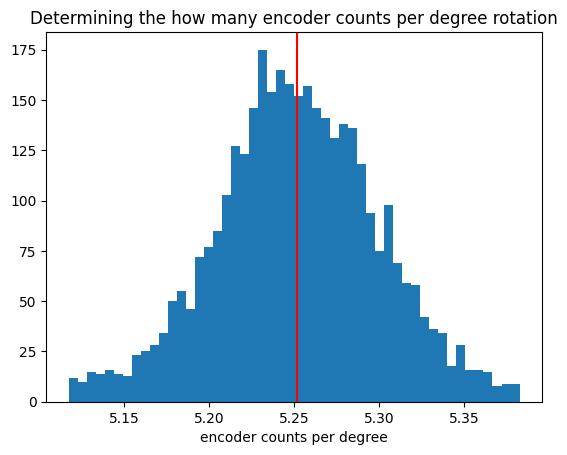

In [29]:
_ = plt.hist(ep.filter_outliers(turn_df['enc_per_deg']), bins = 50)
plt.axvline(ep.filter_outliers(turn_df['enc_per_deg']).mean(),c = 'r')
ep.filter_outliers(turn_df['enc_per_deg']).mean()
plt.xlabel('encoder counts per degree')
plt.title('Determining the how many encoder counts per degree rotation')

## Summary stats

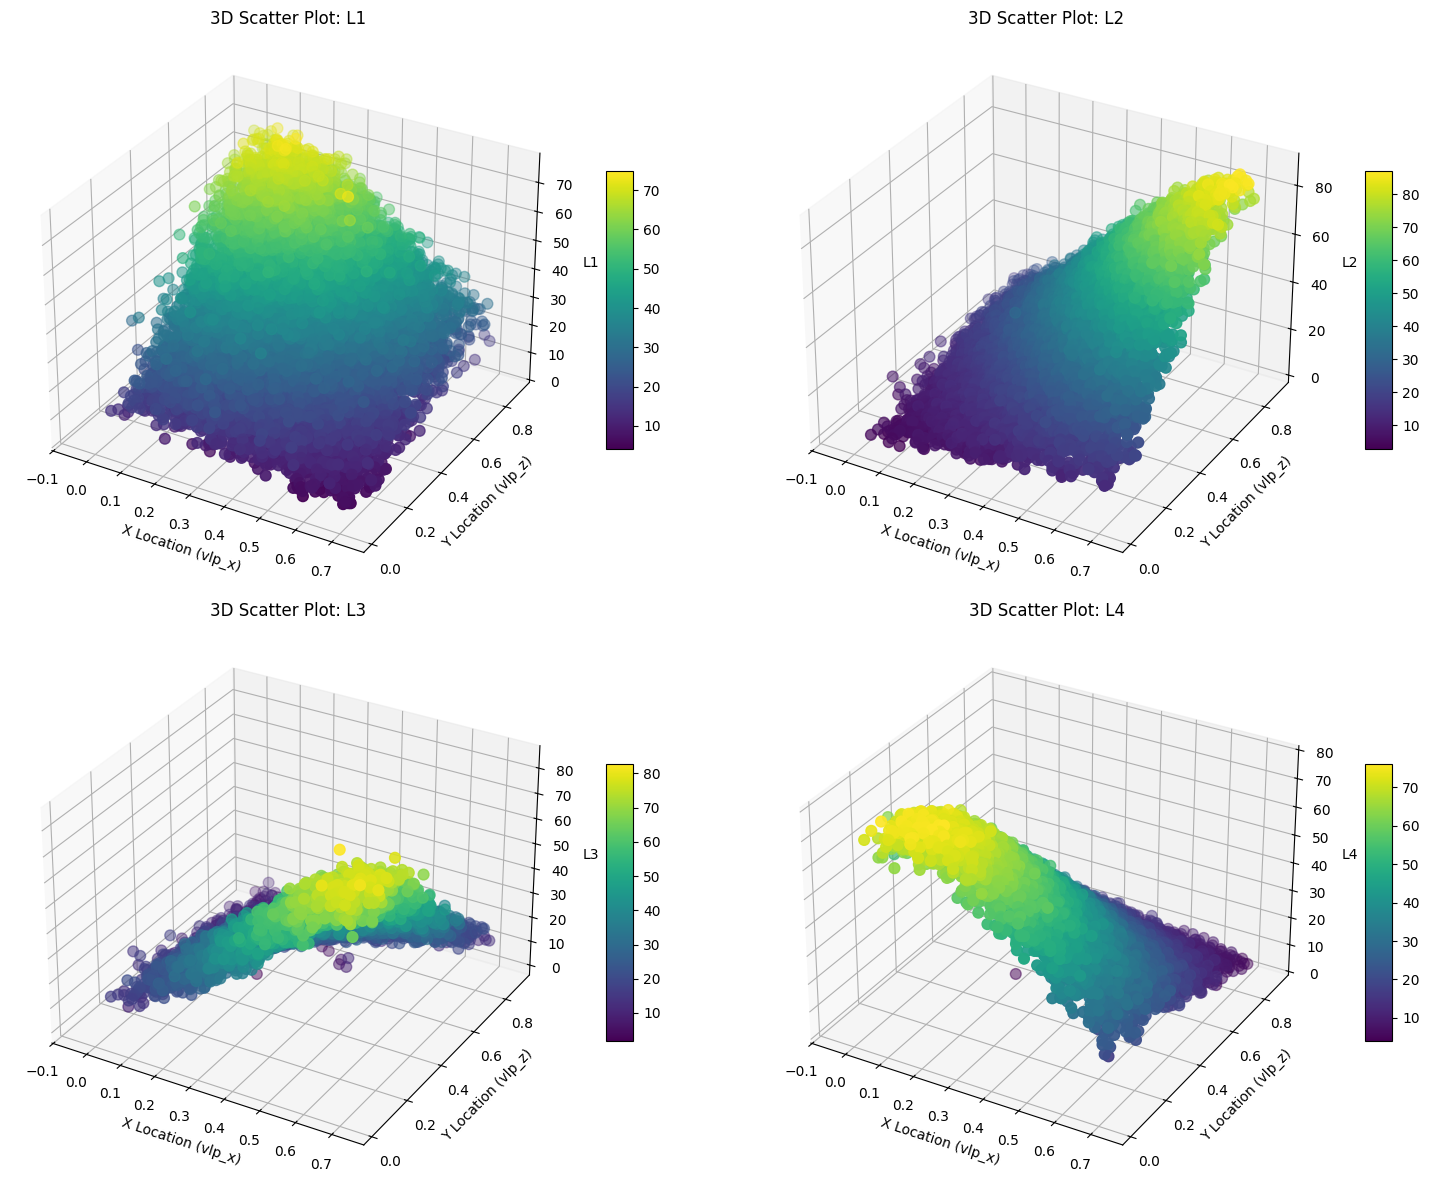

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt_df = df.dropna(subset=['L1', 'x_hist', 'y_hist'])

# Creating 4 subplots for each target peak column
fig = plt.figure(figsize=(16, 12))
target_peaks = ['L1', 'L2', 'L3', 'L4']

# Iterate through each target peak column to create a 3D scatter plot
for i, peak in enumerate(target_peaks):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')  # 2x2 grid of subplots

    # Prepare the scatter plot data
    x = plt_df['x_hist']
    y = plt_df['y_hist']
    z = plt_df[peak]

    # Plot the scatter points; color is mapped to z-values
    scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o', s=60)

    # Add color bar
    fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)

    # Label the axes
    ax.set_title(f'3D Scatter Plot: {peak}')
    ax.set_xlabel('X Location (vlp_x)')
    ax.set_ylabel('Y Location (vlp_z)')
    ax.set_zlabel(peak)

# Show the figure
plt.tight_layout()
plt.show()


# Finding error distribution

<Axes: >

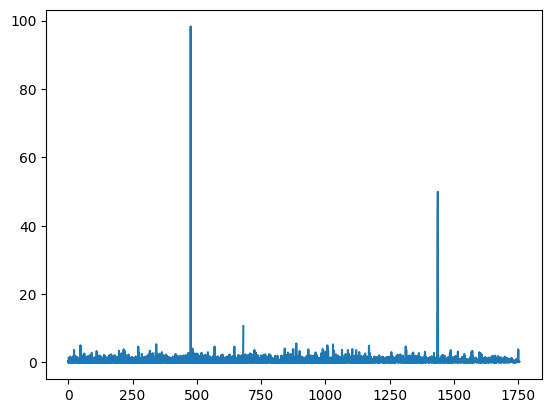

In [30]:
df['encoder_heading_change_err'].apply(c.normalize_angle).abs().plot()

In [31]:
def calc_pos_err(df):
    x = df['x_hist']
    y = df['y_hist']
    ex = df['encoder_x_hist']
    ey = df['encoder_y_hist']
    return np.sqrt(np.square(x - ex) + np.square(y - ey))
def calc_heading_err(df):
    heading = df['heading_hist']
    eheading = df['encoder_heading_hist']
    return np.array([abs(c.normalize_angle(a)) for a in (heading - eheading)])

def calc_vlp_pos_err_test(df):
    x = df['x_hist']
    y = df['y_hist']
    ex = df['vlp_x_hist_test']
    ey = df['vlp_y_hist_test']
    return np.sqrt(np.square(x - ex) + np.square(y - ey))

def calc_vlp_pos_err(df):
    x = df['x_hist']
    y = df['y_hist']
    ex = df['vlp_x_hist']
    ey = df['vlp_y_hist']
    return np.sqrt(np.square(x - ex) + np.square(y - ey))
def calc_vlp_heading_err(df):
    heading = df['heading_hist']
    eheading = df['vlp_heading_hist']
    return np.array([abs(c.normalize_angle(a)) for a in (heading - eheading)])

In [32]:
df.reset_index(drop = True, inplace = True)

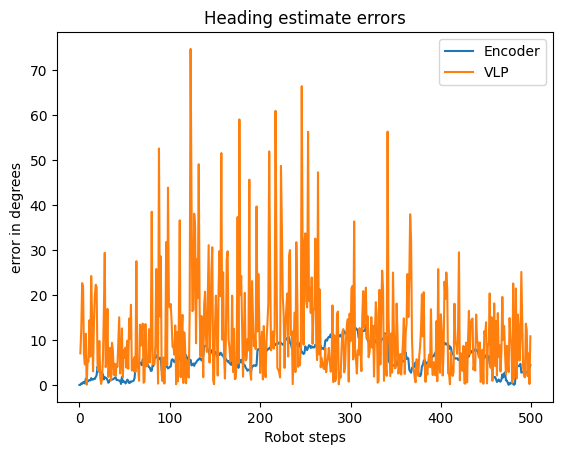

In [33]:
start_index = 0
end_index = start_index + 500

df = df_lst[0]


reset_df = df.iloc[start_index:end_index].copy().reset_index()
reset_df = ep.calc_encoder_heading_hist(reset_df)
reset_df = ep.calc_encoder_xy_hist(reset_df)
pos_err = calc_pos_err(reset_df)
head_err = calc_heading_err(reset_df)
# pos_errs.append(pos_err)
# head_errs.append(head_err)
# vlp_pos_errs.append(calc_vlp_pos_err(reset_df))
# vlp_heading_errs.append(calc_vlp_heading_err(reset_df))
plt.figure()
plt.plot(head_err, label = 'Encoder')
plt.plot(calc_vlp_heading_err(reset_df), label = 'VLP')
plt.title('Heading estimate errors')
plt.ylabel('error in degrees')
plt.xlabel('Robot steps')
plt.legend()
plt.savefig(FIGURES_DIR/'methodology-robot_nav_ang_err_run.png')

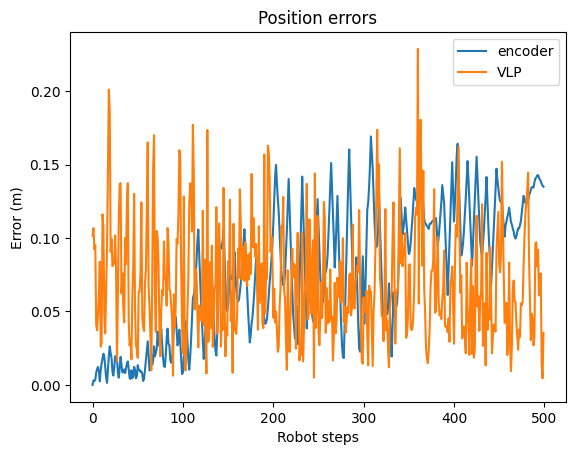

In [34]:
plt.figure()
plt.title('Position errors')

plt.plot(pos_err, label = 'encoder')
plt.plot(calc_vlp_pos_err(reset_df), label = 'VLP')
plt.xlabel('Robot steps')
plt.ylabel('Error (m)')
plt.legend()
plt.savefig(FIGURES_DIR/'methodology-robot_nav_pos_err_run.png')

### Run stats over all dataframe

In [33]:
[len(df) for df in df_lst]

[1685, 1727, 1522, 1742, 1060, 1498, 1159, 1757, 682, 354]

In [32]:
df = df_lst[0]

In [43]:
win_len = 500
len_data_to_include = 1685
start_offset = 0
pos_errs = []
head_errs = []
vlp_pos_errs = []
vlp_heading_errs = []

for i in range(start_offset, start_offset + len_data_to_include - win_len, 1):
    reset_df = df.iloc[i:i+win_len].copy().reset_index()
    reset_df = ep.calc_encoder_heading_hist(reset_df)
    reset_df = ep.calc_encoder_xy_hist(reset_df)
    pos_err = calc_pos_err(reset_df)
    head_err = calc_heading_err(reset_df)
    pos_errs.append(pos_err)
    head_errs.append(head_err)
    vlp_pos_errs.append(calc_vlp_pos_err(reset_df))
    vlp_heading_errs.append(calc_vlp_heading_err(reset_df))

### Heading stats

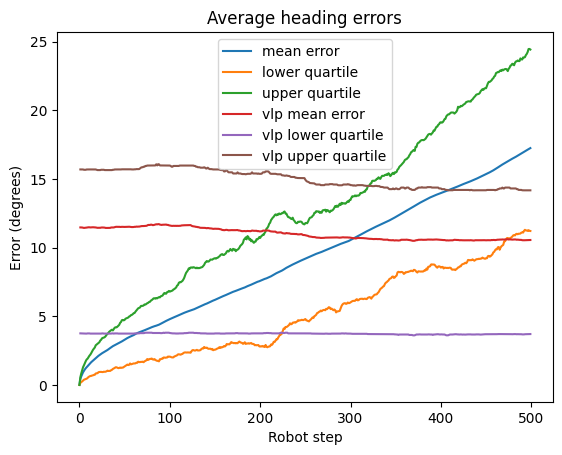

In [44]:
med_err = np.median(np.array(head_errs), axis = 0)
mean_err = np.array(head_errs).mean(axis = 0)
q1_err = np.quantile(np.array(head_errs), 0.25, axis = 0)
q3_err = np.quantile(np.array(head_errs), 0.75, axis = 0)

med_vlp_err = np.median(np.array(vlp_heading_errs), axis = 0)
mean_vlp_err = np.array(vlp_heading_errs).mean(axis = 0)
q1_vlp_err = np.quantile(np.array(vlp_heading_errs), 0.25, axis = 0)
q3_vlp_err = np.quantile(np.array(vlp_heading_errs), 0.75, axis = 0)

# plt.plot(med_err, label = 'median err')
plt.plot(mean_err, label = 'mean error')
plt.plot(q1_err, label = 'lower quartile')
plt.plot(q3_err, label = 'upper quartile')

# plt.plot(med_vlp_err, label = 'vlp median err')
plt.plot(mean_vlp_err, label = 'vlp mean error')
plt.plot(q1_vlp_err, label = 'vlp lower quartile')
plt.plot(q3_vlp_err, label = 'vlp upper quartile')

plt.title('Average heading errors')
plt.legend()
plt.xlabel('Robot step')
plt.ylabel('Error (degrees)')

plt.savefig(FIGURES_DIR/'methodology-robot_nav_ang_err_average.png')

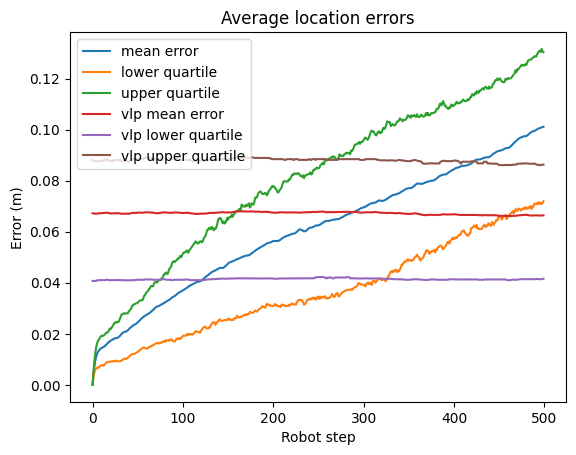

In [45]:
med_err = np.median(np.array(pos_errs), axis = 0)
mean_err = np.array(pos_errs).mean(axis = 0)
q1_err = np.quantile(np.array(pos_errs), 0.25, axis = 0)
q3_err = np.quantile(np.array(pos_errs), 0.75, axis = 0)

med_vlp_err = np.median(np.array(vlp_pos_errs), axis = 0)
mean_vlp_err = np.array(vlp_pos_errs).mean(axis = 0)
q1_vlp_err = np.quantile(np.array(vlp_pos_errs), 0.25, axis = 0)
q3_vlp_err = np.quantile(np.array(vlp_pos_errs), 0.75, axis = 0)

# plt.plot(med_err, label = 'median err')
plt.plot(mean_err, label = 'mean error')
plt.plot(q1_err, label = 'lower quartile')
plt.plot(q3_err, label = 'upper quartile')

# plt.plot(med_vlp_err, label = 'vlp median err')
plt.plot(mean_vlp_err, label = 'vlp mean error')
plt.plot(q1_vlp_err, label = 'vlp lower quartile')
plt.plot(q3_vlp_err, label = 'vlp upper quartile')

plt.title('Average location errors')
plt.legend()
plt.xlabel('Robot step')
plt.ylabel('Error (m)')

plt.savefig(FIGURES_DIR/'methodology-robot_nav_pos_err_average.png')